# Practice PS07: Outlier analysis

The objective of this session is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Guillem Escriba Molto</font>

E-mail: <font color="blue">guillem.escriba01@estudiant.upf.edu</font>

Date: <font color="blue">22/11/2022</font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

In [2]:
# LEAVE AS-IS

df = pd.read_csv('annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

In [3]:
display(df.head(5))

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal


In [4]:
total = len(df)
normal = df[df['result'] == "normal"]['result'].count()
abnormal = df[df['result'] == "abnormal"]['result'].count()
print("Count of patients with normal tyroid = {} ({}%)".format(normal
      , round((normal/total)*100,2)))
print("Count of patients with abnormal tyroid = {} ({}%)".format(abnormal
      , round((abnormal/total)*100,2)))

Count of patients with normal tyroid = 6666 (92.58%)
Count of patients with abnormal tyroid = 534 (7.42%)


In [5]:
n = 0
m = 0
for idx,row in df.iterrows():
    if row[6] == 'normal' and n < 10:
        print(row)
        print()
        n +=1
    elif row[6] == 'abnormal' and m < 10:
        print(row)
        print()
        m +=1
    elif n == 9 and m == 9:
        break

normal_centroid= df[df['result'] == "normal"].mean()
abnormal_centroid = df[df['result'] == "abnormal"].mean()
print("Avg of features of patients with normal tyroid:\n\n", normal_centroid)
print("Avg of features of patients with abnormal tyroid:\n\n",abnormal_centroid)

f1          0.73
f2        0.0006
f3         0.015
f4          0.12
f5         0.082
f6         0.146
result    normal
Name: 0, dtype: object

f1           0.24
f2        0.00025
f3           0.03
f4          0.143
f5          0.133
f6          0.108
result     normal
Name: 1, dtype: object

f1          0.47
f2        0.0019
f3         0.024
f4         0.102
f5         0.131
f6         0.078
result    normal
Name: 2, dtype: object

f1          0.64
f2        0.0009
f3         0.017
f4         0.077
f5          0.09
f6         0.085
result    normal
Name: 3, dtype: object

f1           0.23
f2        0.00025
f3          0.026
f4          0.139
f5           0.09
f6          0.153
result     normal
Name: 4, dtype: object

f1           0.69
f2        0.00025
f3          0.016
f4          0.086
f5           0.07
f6          0.123
result     normal
Name: 5, dtype: object

f1           0.85
f2        0.00025
f3          0.023
f4          0.128
f5          0.104
f6          0.121
result     no

<font size="+1">
Taking into account only the means we can clearly see that the feature f2 differs a lot from normal to abnormal tyroids so it could be an useful feature to classify them. Also are good features f3, f4 and f6 but not as good as f2. It seems that f1 and f5 are very similar between tests.</font>

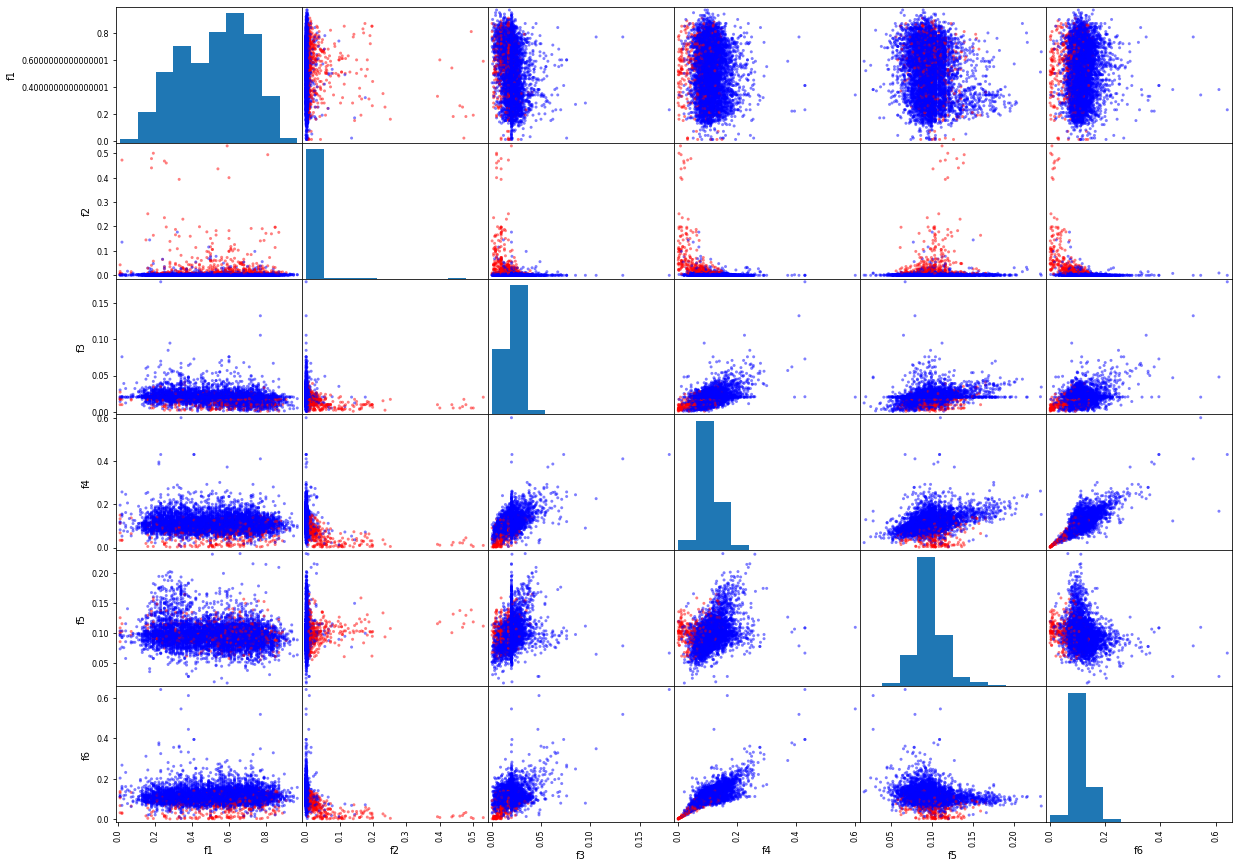

In [6]:
color_code = {'abnormal': 'red', 'normal': 'blue'}

colors = df['result'].apply(lambda x: color_code[x])

pd.plotting.scatter_matrix(df, c=colors, figsize = (20,15))
plt.show()

<font size="+1">
We can clearly see that in those combinations of features which are representative such as f2, is possible to differentiate two defined clusters between abnormal and normal instead in those who are not different like f1 and f5 we cannot see any cluster, the best example is f5-f1 where is a uniform cluster.
</font>

# 1. Create isolation tree

## 1.1. Random dimension and random split

In [8]:
def pick_random_dimension(df, columns_to_ignore):
    columns = df.columns
    n = len(columns)
    while(True):
        f = random.randint(0,n-1) # select a random feature
        if(columns[f] not in columns_to_ignore): # if that feature is not in columns to ignore it returns that feature
            return columns[f]
    
    

In [9]:
columns_to_ignore = ['f1','f2','f3','f4','f5','result']
print(pick_random_dimension(df, columns_to_ignore))
columns_to_ignore = ['result']
print(pick_random_dimension(df, columns_to_ignore))

f6
f5


In [10]:
def pick_random_split(df, dimension):
    min_ = np.min(df[dimension])
    max_ = np.max(df[dimension])
    split_point = random.uniform(min_,max_) # generates a random split point within boundaries of the feature
    return split_point

In [11]:
columns_to_ignore = ['result']
dimension = pick_random_dimension(df, columns_to_ignore)
print(pick_random_split(df, dimension))

columns_to_ignore = ['result']
dimension = pick_random_dimension(df, columns_to_ignore)
print(pick_random_split(df, dimension))

0.1851591085322034
0.4747444366292349


## 1.2. Implement split data into two

In [13]:
def split_dataset(df, dimension, split):
    left = df[df[dimension] <= split] # Splits the df in a new df where the values of dimension are smaller than the split value
    right = df[df[dimension] > split]
    return (left,right)

In [14]:
(left, right) = split_dataset(df, 'f1', 0.4)
display(left)
display(right)

,f1,f2,f3,f4,f5,f6,result
1,0.24,0.00025,0.0300,0.143,0.133,0.108,normal
4,0.23,0.00025,0.0260,0.139,0.090,0.153,normal
11,0.18,0.00010,0.0230,0.098,0.085,0.115,normal
15,0.39,0.00010,0.0180,0.090,0.071,0.126,normal
16,0.39,0.00060,0.0200,0.114,0.100,0.114,normal
...,...,...,...,...,...,...,...
7166,0.36,0.00097,0.0201,0.101,0.077,0.131,normal
7167,0.36,0.00340,0.0469,0.172,0.087,0.198,normal
7179,0.33,0.00230,0.0201,0.077,0.083,0.093,normal
7180,0.30,0.00170,0.0230,0.083,0.081,0.102,normal


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
2,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
5,0.69,0.00025,0.0160,0.086,0.070,0.1230,normal
6,0.85,0.00025,0.0230,0.128,0.104,0.1210,normal
...,...,...,...,...,...,...,...
7194,0.79,0.00490,0.0201,0.077,0.082,0.0940,normal
7195,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal


## 1.3. Create one isolation tree

In [15]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


In [16]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items: # if we have reached the min items we stop creating more branches of the tree and we create a leaf of min_items size or less
        return {"contents": data}
    else:
        dimension = pick_random_dimension(data, columns_to_ignore) # random selection of feature
        split = pick_random_split(data, dimension) # random selection of split threshold
        (left,right) = split_dataset(data, dimension, split) # split the df
        left = isolation_tree(left, columns_to_ignore, min_items) # recursive call to the isolation tree function for left and right
        right = isolation_tree(right, columns_to_ignore, min_items)
        tree = {"left": left, "right": right, "dimension": dimension, "split": split}
        return tree   
    

In [17]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

In [18]:
# LEAVE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [19]:
print(tree_to_nodes(mytree))

:'internal node: f4 <= 0.38'
-<:'internal node: f5 <= 0.09'
--<:'external node: 1862 normal + 128 abnormal'
-->:'internal node: f1 <= 0.72'
---<:'internal node: f4 <= 0.30'
----<:'internal node: f1 <= 0.17'
-----<:'external node: 110 normal + 13 abnormal'
----->:'internal node: f6 <= 0.14'
------<:'internal node: f5 <= 0.14'
-------<:'internal node: f3 <= 0.08'
--------<:'internal node: f5 <= 0.12'
---------<:'internal node: f6 <= 0.04'
----------<:'external node: 22 normal + 68 abnormal'
---------->:'internal node: f4 <= 0.15'
-----------<:'internal node: f5 <= 0.11'
------------<:'internal node: f2 <= 0.10'
-------------<:'internal node: f5 <= 0.09'
--------------<:'external node: 630 normal + 43 abnormal'
-------------->:'internal node: f5 <= 0.11'
---------------<:'external node: 1722 normal + 123 abnormal'
--------------->:'external node: 207 normal + 14 abnormal'
------------->:'external node: 2 normal + 3 abnormal'
------------>:'external node: 450 normal + 35 abnormal'
--------

In [20]:
def get_max_tree_depth_aux(tree, depth): # auxiliar function
    depth_r = 0
    depth_l = 0
    if 'right' not in tree and 'left' not in tree: # if there is no child then it is a leaf so is the max depth of this path
        return depth
    else:
        if 'right' in tree: # if there is a child we continue computing recursively the depth
            depth_r = get_max_tree_depth_aux(tree['right'], depth+1)
        if 'left' in tree:
            depth_l = get_max_tree_depth_aux(tree['left'], depth+1)
        depth = max(depth_r,depth_l) # we compare which of both is the deepest leaf
        return depth
    
def get_max_tree_depth(tree): # avoids one parameter of the recursion
    return get_max_tree_depth_aux(tree, 0) 

In [21]:
get_max_tree_depth(mytree)

15

## 2.1. Create an isolation forest

In [22]:
def isolation_forest(dfi, columns_to_ignore, min_items, num_trees):
    forest = []
    for i in range(num_trees):
        tree = isolation_tree(dfi, columns_to_ignore, min_items) # create forests and append to the array
        forest.append(tree)
    return forest

In [23]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 100
num_trees = 30

In [24]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


In [25]:
# Leave this code as-is

for i in range(0, 3):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f4 <= 0.15'
-<:'internal node: f3 <= 0.01'
--<:'internal node: f5 <= 0.12'
---<:'internal node: f2 <= 0.10'
----<:'internal node: f2 <= 0.01'
-----<:'internal node: f6 <= 0.08'
------<:'external node: 33 normal + 5 abnormal'
------>:'external node: 85 normal + 8 abnormal'
----->:'external node: 2 normal + 29 abnormal'
---->:'external node: 0 normal + 13 abnormal'
--->:'external node: 2 normal + 11 abnormal'
-->:'internal node: f4 <= 0.06'
---<:'internal node: f6 <= 0.07'
----<:'internal node: f2 <= 0.14'
-----<:'internal node: f3 <= 0.05'
------<:'internal node: f2 <= 0.02'
-------<:'external node: 64 normal + 11 abnormal'
------->:'external node: 4 normal + 49 abnormal'
------>:'external node: 1 normal + 0 abnormal'
----->:'external node: 1 normal + 21 abnormal'
---->:'external node: 34 normal + 2 abnormal'
--->:'internal node: f5 <= 0.08'
----<:'internal node: f5 <= 0.05'
-----<:'external node: 13 normal + 0 abnormal'
----->:'internal node: f6 <= 0.15'


## 2.2. Find the average depth of an item

In [26]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [27]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 15
Depths for normal items
- id=P4283 is at depth 15/15
- id=P4559 is at depth 2/15
- id=P0995 is at depth 14/15
- id=P4747 is at depth 6/15
- id=P3848 is at depth 3/15
Depths for abnormal items
- id=P2813 is at depth 9/15
- id=P1166 is at depth 15/15
- id=P6627 is at depth 14/15
- id=P4926 is at depth 3/15
- id=P4156 is at depth 15/15

On first tree of forest, having maximum depth 37
Depths for normal items
- id=P0549 is at depth 37/37
- id=P2958 is at depth 37/37
- id=P3788 is at depth 27/37
- id=P4297 is at depth 17/37
- id=P1154 is at depth 8/37
Depths for abnormal items
- id=P2994 is at depth 24/37
- id=P2423 is at depth 10/37
- id=P0839 is at depth 9/37
- id=P5251 is at depth 14/37
- id=P5113 is at depth 11/37



<font size="+1">As we can see abnormal items are less deep than normal items due to they are very spares so when we split the df in several cuts they reach the stated min items earlier.</font>

In [28]:
def find_average_depth(forest, column_name, value):
    n = len(forest)
    avg_depth = 0
    for tree in forest:
        avg_depth += (1/n)*find_element_depth(tree, column_name, value) # average of all computed depth
    return avg_depth
    

In [29]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P4560 is at average depth 21.9
- id=P2529 is at average depth 18.3
- id=P0307 is at average depth 16.2
- id=P4652 is at average depth 20.6
- id=P0826 is at average depth 10.6

Average depths for abnormal items
- id=P5508 is at average depth 5.5
- id=P0921 is at average depth 17.4
- id=P6306 is at average depth 19.0
- id=P0958 is at average depth 16.5
- id=P5608 is at average depth 17.3



<font size="+1">The best way I think to make it possible is to visit all nodes by proximity instead of looking for a specific node or so. Then, when I have reached that node I store it and procced with the closest neighbour right and left until I have ended.</font>

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [30]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(50))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(50))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P3195', 'P6373', 'P5582', 'P0081', 'P5207', 'P1523', 'P0959', 'P4549', 'P5793', 'P0244', 'P5305', 'P6744', 'P5675', 'P2782', 'P7078', 'P0897', 'P1314', 'P4720', 'P0724', 'P5583', 'P3342', 'P5651', 'P4004', 'P3496', 'P2501', 'P6709', 'P6435', 'P4530', 'P1543', 'P2352', 'P3303', 'P4291', 'P2789', 'P7026', 'P3875', 'P6467', 'P6023', 'P5968', 'P1297', 'P5428', 'P4016', 'P5376', 'P5044', 'P7044', 'P6461', 'P4492', 'P1339', 'P5536', 'P6332', 'P1826']
Abnormal point sample ids : ['P5003', 'P2939', 'P3563', 'P4115', 'P3437', 'P6769', 'P0106', 'P5605', 'P4696', 'P5276', 'P5449', 'P4268', 'P4420', 'P2457', 'P3204', 'P3920', 'P0640', 'P0936', 'P3197', 'P1524', 'P4672', 'P6718', 'P6482', 'P3577', 'P1707', 'P1210', 'P2896', 'P5558', 'P3676', 'P7029', 'P0861', 'P5509', 'P3007', 'P3246', 'P2241', 'P2938', 'P0778', 'P2171', 'P6655', 'P1469', 'P1276', 'P5614', 'P4614', 'P2445', 'P3908', 'P2105', 'P7077', 'P0216', 'P6883', 'P6947']


In [31]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P3195 is at average depth 22.53
 element id=P6373 is at average depth 11.00
 element id=P5582 is at average depth 21.97
 element id=P0081 is at average depth 21.73
 element id=P5207 is at average depth 18.67
 element id=P1523 is at average depth 18.90
 element id=P0959 is at average depth 20.40
 element id=P4549 is at average depth 20.37
 element id=P5793 is at average depth 18.73
 element id=P0244 is at average depth 20.27
 element id=P5305 is at average depth 20.60
 element id=P6744 is at average depth 16.13
 element id=P5675 is at average depth 20.37
 element id=P2782 is at average depth 21.77
 element id=P7078 is at average depth 7.67
 element id=P0897 is at average depth 21.10
 element id=P1314 is at average depth 13.47
 element id=P4720 is at average depth 18.87
 element id=P0724 is at average depth 22.00
 element id=P5583 is at average depth 19.00
 element id=P3342 is at average depth 21.30
 element id=P5651 is at average depth

In [32]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P5003 is at average depth 15.57
 element id=P2939 is at average depth 19.00
 element id=P3563 is at average depth 6.83
 element id=P4115 is at average depth 14.47
 element id=P3437 is at average depth 17.43
 element id=P6769 is at average depth 11.37
 element id=P0106 is at average depth 11.43
 element id=P5605 is at average depth 18.83
 element id=P4696 is at average depth 16.03
 element id=P5276 is at average depth 14.70
 element id=P5449 is at average depth 14.60
 element id=P4268 is at average depth 14.97
 element id=P4420 is at average depth 7.90
 element id=P2457 is at average depth 16.23
 element id=P3204 is at average depth 19.07
 element id=P3920 is at average depth 10.53
 element id=P0640 is at average depth 13.13
 element id=P0936 is at average depth 13.73
 element id=P3197 is at average depth 16.87
 element id=P1524 is at average depth 18.17
 element id=P4672 is at average depth 7.77
 element id=P6718 is at average depth

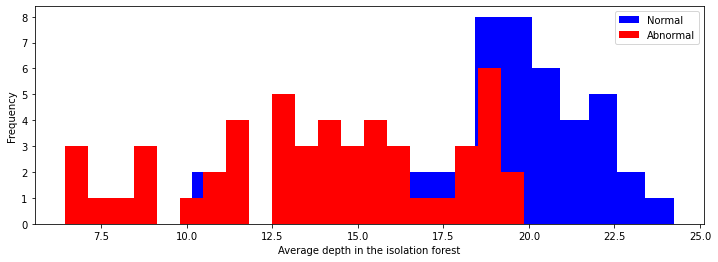

In [33]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1">As I said before, abnormal nodes have a lower average depth than the normal ones.</font>

## 3.2. Compute outlier scores and conclude

In [34]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [35]:
# LEAVE AS-IS

def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

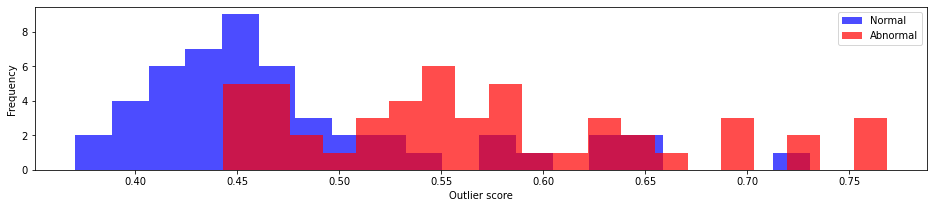

In [36]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font size="+1">Even if there are some outliers the abnormal tend to have an score higher than 0'5 and normal patients lower than 0'55 so a good threshold would be 0'5-0'52.</font>

In [38]:
normal, abnormal, fp, fn, tp, tn = 0, 0, 0, 0, 0, 0

In [62]:
THRESHOLD = 0.50
outlier_scores = np.concatenate((abnormal_scores, normal_scores))
normal, abnormal, fp, fn, tp, tn = 0, 0, 0, 0, 0, 0

for i in range(len(outlier_scores)):
    if outlier_scores[i] <= THRESHOLD:
        normal += 1
        if i < len(abnormal_scores):
            fp += 1
        else:
            tp += 1
    else:
        abnormal += 1
        if i < len(abnormal_scores):
            tn += 1
        else:
            fn += 1


print('Percentages of normal and abnormal: {}% and {}%'.format( normal / len(normal_scores) *100, abnormal / len(abnormal_scores) *100))
print('False positive rate:',  fp / len(abnormal_scores)*100, "%")
print('False negative rate:', fn / len(normal_scores)*100, "%")

Percentages of normal and abnormal: 100.0% and 100.0%
False positive rate: 24.0 %
False negative rate: 24.0 %


<font size="+1">After using different thresholds, the one who has the best tradeoff between fp rate and fn rate is 0'5. If we reduce the threshold fp tends to 0 while fn tends to 100% and viceversa.</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>